In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision.datasets import MNIST

C:\Users\shdhk\anaconda3\envs\agent\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\shdhk\anaconda3\envs\agent\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
plt.style.use("ggplot")
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
CHANNELS, IMG_ROWS, IMG_COLS = 1, 28, 28
IMG_SHAPE = (CHANNELS, IMG_ROWS, IMG_COLS)
Z_DIM = 100
NUM_CLASSES = 10

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(z_dim, 256 * 7 * 7)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(-1, 256, 7, 7)
        output = self.model(x)
        return output


class ConditionalGenerator(nn.Module):
    def __init__(self, z_dim):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_embeddings=NUM_CLASSES, embedding_dim=z_dim)
        self.generator = Generator(z_dim=z_dim).to(DEVICE)

    def forward(self, x, label=torch.LongTensor([0]).to(DEVICE)):
        label_embedding = self.label_embedding(label)
        x = torch.mul(x, label_embedding)
        output = self.generator(x)
        return output


cond_gen = ConditionalGenerator(Z_DIM).to(DEVICE)
summary(cond_gen, (100, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                  [-1, 100]           1,000
            Linear-2                [-1, 12544]       1,266,944
   ConvTranspose2d-3          [-1, 128, 14, 14]         295,040
       BatchNorm2d-4          [-1, 128, 14, 14]             256
         LeakyReLU-5          [-1, 128, 14, 14]               0
   ConvTranspose2d-6           [-1, 64, 14, 14]          73,792
       BatchNorm2d-7           [-1, 64, 14, 14]             128
         LeakyReLU-8           [-1, 64, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]             577
             Tanh-10            [-1, 1, 28, 28]               0
        Generator-11            [-1, 1, 28, 28]               0
Total params: 1,637,737
Trainable params: 1,637,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=img_shape[0] + 1, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=0),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Flatten(),
            nn.Linear(3 * 3 * 128, 1),
        )

    def forward(self, x):
        x = self.model(x)
        return x


class ConditionalDiscriminator(nn.Module):
    def __init__(self, img_shape):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_embeddings=NUM_CLASSES, embedding_dim=np.prod(img_shape))
        self.discriminator = Discriminator(img_shape=img_shape).to(DEVICE)
        self.img_shape = img_shape

    def forward(self, x, label=torch.LongTensor([0, 1]).to(DEVICE)):
        label_embedding = self.label_embedding(label)
        label_embedding = label_embedding.reshape(-1, *self.img_shape)
        x = torch.cat((x, label_embedding), dim=1)
        output = self.discriminator(x)
        return output


cond_dis = ConditionalDiscriminator(img_shape=IMG_SHAPE).to(DEVICE)
summary(cond_dis, IMG_SHAPE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                  [-1, 784]           7,840
            Conv2d-2           [-1, 64, 14, 14]           1,216
         LeakyReLU-3           [-1, 64, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          36,928
         LeakyReLU-5             [-1, 64, 7, 7]               0
            Conv2d-6            [-1, 128, 3, 3]          73,856
         LeakyReLU-7            [-1, 128, 3, 3]               0
           Flatten-8                 [-1, 1152]               0
            Linear-9                    [-1, 1]           1,153
    Discriminator-10                    [-1, 1]               0
Total params: 120,993
Trainable params: 120,993
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.46
Estimated T

In [5]:
optimizer_d = optim.Adam(cond_dis.parameters(), lr=0.002)
optimizer_g = optim.Adam(cond_gen.parameters(), lr=0.002)
criterion = nn.BCEWithLogitsLoss()

In [12]:
def sample_images(generator, iteration, image_grid_rows=2, image_grid_cols=5, path="./Chapter08_image"):
    if not os.path.exists(path):
        os.mkdir(path)
    z = torch.randn(image_grid_rows * image_grid_cols, Z_DIM).to(DEVICE)
    labels = torch.arange(0, 10).to(DEVICE)
    with torch.no_grad():
        generator.eval()
        gen_imgs = generator(z, labels)
        gen_imgs = 0.5 * gen_imgs + 0.5
        gen_imgs = gen_imgs.detach().to(torch.device("cpu")).numpy()
    fig, axes = plt.subplots(image_grid_rows, image_grid_cols, figsize=(5, 2), sharey=True, sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_cols):
            axes[i, j].imshow(gen_imgs[cnt, 0, :, :], cmap="gray")
            axes[i, j].axis("off")
            axes[i, j].set_title(f"Digit: {cnt}")
            cnt += 1
    plt.tight_layout()
    plt.savefig(f"{path}/img_{iteration:03d}")
    plt.close()

In [13]:
losses, iteration_checkpoints = [], []
iterations = 20000
batch_size = 128
sample_interval = 1000

download_root = "./MNIST_DATASET"
train_dataset = MNIST(download_root, train=True, download=True)
train_img = (train_dataset.data / 127.5) - 1.0
train_img = torch.unsqueeze(train_img, 1)
train_label = train_dataset.targets

real = torch.ones(batch_size, 1).to(DEVICE)
fake = torch.zeros(batch_size, 1).to(DEVICE)

for iteration in range(iterations):
    idx = np.random.randint(low=0, high=train_img.shape[0], size=batch_size)
    real_imgs, real_labels = train_img[idx].to(DEVICE), train_label[idx].to(DEVICE)

    z = torch.randn(batch_size, Z_DIM).to(DEVICE)
    gen_imgs = cond_gen(z, real_labels)

    optimizer_d.zero_grad()
    d_pred_real, d_pred_fake = cond_dis(real_imgs, real_labels), cond_dis(gen_imgs, real_labels)
    d_loss_real, d_loss_fake = criterion(d_pred_real, real), criterion(d_pred_fake, fake)
    d_loss = (d_loss_real + d_loss_fake) * 0.5
    d_loss.backward()
    optimizer_d.step()

    z = torch.randn(batch_size, Z_DIM).to(DEVICE)
    fake_labels = torch.randint(low=0, high=NUM_CLASSES, size=(batch_size, )).to(DEVICE)
    gen_imgs = cond_gen(z, fake_labels)

    optimizer_g.zero_grad()
    d_pred_fake = cond_dis(gen_imgs, fake_labels)
    g_loss = criterion(d_pred_fake, real)
    g_loss.backward()
    optimizer_g.step()

    if (iteration + 1) % sample_interval == 0:
        losses.append([d_loss.item(), g_loss.item()])
        iteration_checkpoints.append(iteration + 1)
        print(f"{iteration + 1} [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")
        sample_images(cond_gen, iteration=iteration + 1)

1000 [D loss: 0.4514] [G loss: 1.7173]
2000 [D loss: 0.5524] [G loss: 1.8098]
3000 [D loss: 0.5245] [G loss: 1.2164]
4000 [D loss: 0.4556] [G loss: 1.5558]
5000 [D loss: 0.4507] [G loss: 1.4747]
6000 [D loss: 0.5086] [G loss: 1.5084]
7000 [D loss: 0.5534] [G loss: 1.4093]
8000 [D loss: 0.5066] [G loss: 1.4971]
9000 [D loss: 0.5023] [G loss: 1.5637]
10000 [D loss: 0.4661] [G loss: 1.3553]
11000 [D loss: 0.5301] [G loss: 1.3746]
12000 [D loss: 0.4738] [G loss: 1.6397]
13000 [D loss: 0.5023] [G loss: 1.6365]
14000 [D loss: 0.4604] [G loss: 1.4231]
15000 [D loss: 0.5486] [G loss: 1.4474]
16000 [D loss: 0.4759] [G loss: 1.5105]
17000 [D loss: 0.4587] [G loss: 1.7435]
18000 [D loss: 0.4623] [G loss: 1.4436]
19000 [D loss: 0.5095] [G loss: 1.5688]
20000 [D loss: 0.4568] [G loss: 1.6458]


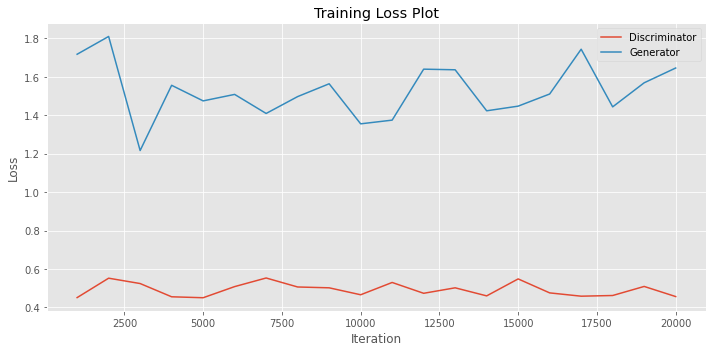

In [14]:
losses_np = np.array(losses)

plt.figure(figsize=(10, 5), tight_layout=True)
plt.plot(iteration_checkpoints, losses_np.T[0], label="Discriminator")
plt.plot(iteration_checkpoints, losses_np.T[1], label="Generator")
plt.title("Training Loss Plot")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(loc="best")